<a href="https://colab.research.google.com/github/PavelStelmakhV/hw306-pyspark/blob/main/Hw6.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=0ce0612d417865266995e22ab31949dcc007c37aaf68142336cc8306feed7d0d
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [2]:
from google.colab import drive
from google.colab import files


drive.mount('/content/drive')
path = '/content/drive/My Drive/'
file_name = 'bestsellers with categories.csv'

Mounted at /content/drive


In [3]:
import pandas as pd
import pyspark
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, round as _round
from pyspark.sql.types import *


In [28]:
spark = SparkSession.builder.getOrCreate()

In [4]:
data_schema = [
               StructField('name', StringType(), True),
               StructField('author', StringType(), True),
               StructField('user_rating', FloatType(), True),
               StructField('reviews', IntegerType(), True),
               StructField('price', FloatType(), True),
               StructField('year', IntegerType(), True),
               StructField('genre', StringType(), True),
            ]

final_struc = StructType(fields = data_schema)

In [5]:
csv_file = path + file_name
df = spark.read.csv(csv_file, header=True, schema=final_struc)

In [30]:
df.show(3)

+--------------------+------------------+-----------+-------+-----+----+-----------+
|                name|            author|user_rating|reviews|price|year|      genre|
+--------------------+------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|          JJ Smith|        4.7|  17350|  8.0|2016|Non Fiction|
|   11/22/63: A Novel|      Stephen King|        4.6|   2052| 22.0|2011|    Fiction|
|12 Rules for Life...|Jordan B. Peterson|        4.7|  18979| 15.0|2018|Non Fiction|
+--------------------+------------------+-----------+-------+-----+----+-----------+
only showing top 3 rows



Используя только RDD вычислить среднюю цену всех книг, у которых рейтинг выше 4.7

In [13]:
df.filter(df.user_rating >= 4.7).agg({"price": "avg"}).show()

+-----------------+
|       avg(price)|
+-----------------+
|10.69832402234637|
+-----------------+



Построить гистограмму распределения рецензий (столбец Reviews).

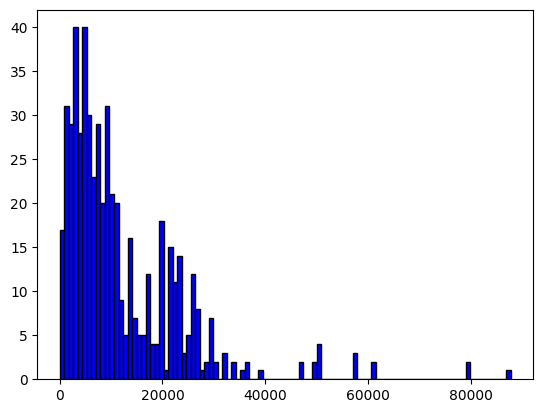

In [27]:
import matplotlib.pyplot as plt

plt.hist(df.toPandas()['reviews'], color = 'blue', edgecolor = 'black', bins = 100)

plt.show()